In [1]:
import torch
import pandas as pd  
import numpy as np  
import matplotlib.pyplot as plt
torch.__version__

'2.0.1'

**Dataset**

In [2]:
df_path = "data/noisy_training_data.xlsx"
df = pd.read_excel(df_path)
df.head()

,G1T1FT,G2T1FT,G3T1FT,G4T1FT,G5T1FT,G1T2FT,G2T2FT,G3T2FT,G4T2FT,G5T2FT,...,GAL1GT2ST,LN,T1,T2,PAL1GFT,PAL1GST,DG,TIMESTAMP,target,noise
0,0,1,0,0,0,1,0,0,0,0,...,0,SUDAMÉRICA: COPA LIBERTADORES SUB-20 - JORNADA 3,Huachipato Sub-20 (Chi),Defensor Sp. Sub-20 (Uru),0.36,0.20,09-07-2023 14:00,1688847909,0,-1.417284
1,0,1,0,0,0,1,2,3,1,1,...,2,SUDAMÉRICA: COPA LIBERTADORES SUB-20 - JORNADA 3,Boca Jrs. Sub-20 (Arg),Palmeiras Sub-20 (Bra),1.00,0.40,09-07-2023 17:00,1688847919,0,0.664096
2,0,1,0,1,1,2,0,0,0,0,...,4,ÁFRICA: COSAFA CUP,Zambia,Comores,0.68,0.92,09-07-2023 08:00,1688847934,1,-0.360942
3,1,0,0,0,0,0,0,0,0,0,...,1,ÁFRICA: COSAFA CUP,Malaui,Seychelles,0.20,0.36,09-07-2023 11:00,1688847947,1,0.131080
4,0,1,1,1,1,0,0,0,0,0,...,2,ARGENTINA: LIGA PROFESIONAL - JORNADA 24,Instituto,Tigre,0.80,0.52,09-07-2023 13:30,1688847960,0,0.677638


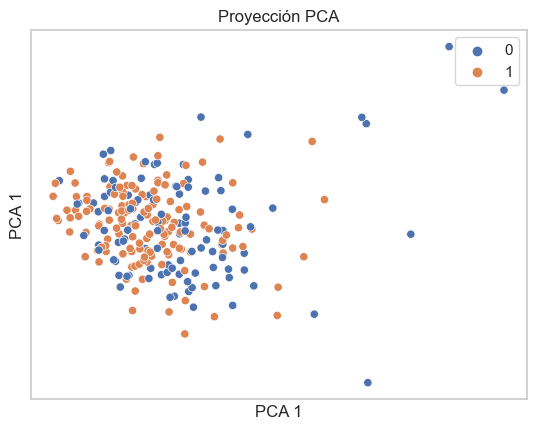

In [3]:
import seaborn as sns
from sklearn import decomposition
sns.set()
pca = decomposition.PCA(n_components=2)

X = df.drop(["target", "DG", "TIMESTAMP",
             "PAL1GFT", "PAL1GST", "LN",
             "T1", "T2"], axis=1)
y = df["target"].values

vecs = pca.fit_transform(X)
x0 = vecs[:, 0]
x1 = vecs[:, 1]

sns.set_style("whitegrid")
sns.scatterplot(x=x0, y=x1, hue=y)
plt.title("Proyección PCA")
plt.xlabel("PCA 1")
plt.ylabel("PCA 1")
plt.xticks([])
plt.yticks([])
plt.show()

**Custom PyTorch Dataset class**

In [4]:
from torch.utils.data import Dataset

class SoccerScoresDataset(Dataset):
    def __init__(self, X, y):
        # tensor de variables predictoras
        self.features = torch.tensor(X, dtype=torch.float32)
        # tensor de variable objetivo
        self.labels = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        # retorna el length del dataset
        return self.features.shape[0]
    
    def __getitem__(self, idx):
        # método que permite indexar y hacer slicing del dataset
        x = self.features[idx]
        y = self.labels[idx]
        return x, y

**Esquema de validación**

In [5]:
from sklearn import model_selection

train_ratio = 0.75
validation_ratio = 0.20
test_ratio = 0.20

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y,
                                                                    test_size=1 - train_ratio)

X_val, X_test, y_val, y_test = model_selection.train_test_split(X_test, y_test,
                                                                    test_size=test_ratio/(test_ratio + validation_ratio))
X_train.shape, X_val.shape, X_test.shape

((188, 29), (31, 29), (32, 29))

**Normalización de los datos**

In [6]:
from sklearn import preprocessing
scaler = preprocessing.StandardScaler()

x_train_scaled = scaler.fit_transform(X_train)
x_val_scaled = scaler.transform(X_val)
x_test_scaled = scaler.transform(X_test)

**Instanciamos los datos escalados al SoccerScoreDataset**

In [7]:
train_dataset = SoccerScoresDataset(x_train_scaled, y_train)
val_dataset = SoccerScoresDataset(x_val_scaled, y_val)
test_dataset = SoccerScoresDataset(x_test_scaled, y_test)

**DataLoader class**

In [8]:
from torch.utils.data import DataLoader

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=16,
    shuffle=True,
    drop_last=True
)
val_loader = DataLoader(
    dataset=val_dataset,
    batch_size=16,
    shuffle=False,
    drop_last=True
)
test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=16,
    shuffle=False,
    drop_last=True
)

**Modelo**

In [9]:
import torch.nn as nn

class LogisticRegression(nn.Module):
    """
    Atributos:    
        num_features - number of features to learn from
        num_classes: number of classes in output to expect (in this case, 1 or 2, since the output is binary (0 or 1))
    """
    def __init__(self, num_features, num_classes):
        super(LogisticRegression, self).__init__()
        self.num_features = num_features # 29
        self.num_classes = num_classes # 1
        # linear layer
        self.linear1 = nn.Linear(num_features, num_classes) # 1x29
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        logits = self.linear1(x)
        probs = self.sigmoid(logits)
        return probs # retorna las probabilidades de cada clase


**Funciones de utilidad**

In [10]:
def compute_accuracy(model, dataloader):
    model = model.eval()
    correct = 0
    total_examples = 0
    for idx, (features, labels) in enumerate(dataloader):
        with torch.no_grad():
            logits = model(features)
        predictions = torch.where(logits > 0.5, 1, 0)
        lab = labels.view(predictions.shape)
        comparison = lab == predictions

        correct += torch.sum(comparison)
        total_examples += len(comparison)
    return correct / total_examples

def plot_results(train_loss, val_loss, train_acc, val_acc):
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    ax[0].plot(
        train_loss, label="train", color="red", linestyle="--", linewidth=2, alpha=0.5
    )
    ax[0].plot(
        val_loss, label="val", color="blue", linestyle="--", linewidth=2, alpha=0.5
    )
    ax[0].set_xlabel("Epoch")
    ax[0].set_ylabel("Loss")
    ax[0].legend()
    ax[1].plot(
        train_acc, label="train", color="red", linestyle="--", linewidth=2, alpha=0.5
    )
    ax[1].plot(
        val_acc, label="val", color="blue", linestyle="--", linewidth=2, alpha=0.5
    )
    ax[1].set_xlabel("Epoch")
    ax[1].set_ylabel("Accuracy")
    ax[1].legend()
    plt.show()

**Training Loop**

In [21]:
import torch.nn.functional as F
num_epochs = 100
learning_rate = 0.01

model = LogisticRegression(num_features=x_train_scaled.shape[1], num_classes=1)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

train_losses, val_losses = list(), list()
train_accs, val_accs = list(), list() 

for epoch in range(num_epochs):
    model = model.train()
    t_loss_list, v_loss_list = [], []
    for batch_idx, (features, labels) in enumerate(train_loader):
        train_probs = model(features)
        train_loss = F.binary_cross_entropy(train_probs, labels.view(train_probs.shape))

        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

        if batch_idx % 10 == 0:
            print(
                f"Epoch {epoch+1:02d}/{num_epochs:02d}"
                f" | Batch {batch_idx:02d}/{len(train_loader):02d}"
                f" | Train Loss {train_loss:.3f}"
            )
        t_loss_list.append(train_loss.item())
    
    model = model.eval()
    for batch_idx, (features, labels) in enumerate(val_loader):
        with torch.no_grad():
            val_probs = model(features)
            val_loss = F.binary_cross_entropy(val_probs, labels.view(val_probs.shape))
            v_loss_list.append(val_loss.item())

    train_losses.append(np.mean(t_loss_list))
    val_losses.append(np.mean(v_loss_list))

    train_acc = compute_accuracy(model, train_loader)
    val_acc = compute_accuracy(model, val_loader)

    train_accs.append(train_acc)
    val_accs.append(val_acc)

    print(
        f"Train accuracy: {train_acc:.2f}"
        f" | Val accuracy: {val_acc:.2f}"
    )

Epoch 01/100 | Batch 00/11 | Train Loss 0.714
Epoch 01/100 | Batch 10/11 | Train Loss 0.685
Train accuracy: 0.56 | Val accuracy: 0.62
Epoch 02/100 | Batch 00/11 | Train Loss 0.608
Epoch 02/100 | Batch 10/11 | Train Loss 0.687
Train accuracy: 0.61 | Val accuracy: 0.62
Epoch 03/100 | Batch 00/11 | Train Loss 0.730
Epoch 03/100 | Batch 10/11 | Train Loss 0.766
Train accuracy: 0.62 | Val accuracy: 0.69
Epoch 04/100 | Batch 00/11 | Train Loss 0.496
Epoch 04/100 | Batch 10/11 | Train Loss 0.768
Train accuracy: 0.66 | Val accuracy: 0.69
Epoch 05/100 | Batch 00/11 | Train Loss 0.637
Epoch 05/100 | Batch 10/11 | Train Loss 0.535
Train accuracy: 0.68 | Val accuracy: 0.75
Epoch 06/100 | Batch 00/11 | Train Loss 0.598
Epoch 06/100 | Batch 10/11 | Train Loss 0.608
Train accuracy: 0.73 | Val accuracy: 0.75
Epoch 07/100 | Batch 00/11 | Train Loss 0.493
Epoch 07/100 | Batch 10/11 | Train Loss 0.615
Train accuracy: 0.76 | Val accuracy: 0.75
Epoch 08/100 | Batch 00/11 | Train Loss 0.506
Epoch 08/100 | B

**Performance evaluation**

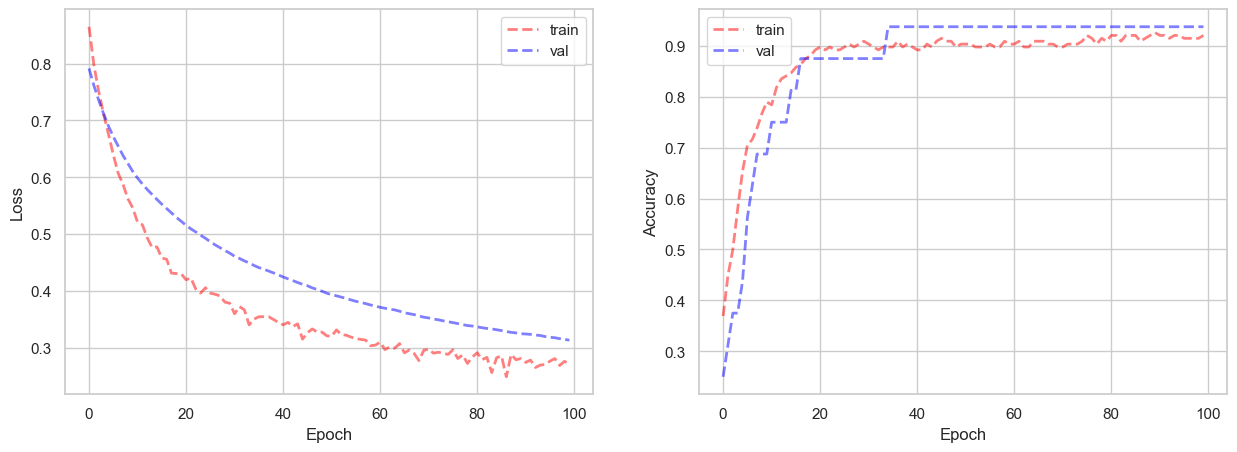

In [12]:
plot_results(train_losses, val_losses, train_accs, val_accs)

**Predicciones**

In [13]:
# transformamos todas las variables con el escalador
X_scalled_all = scaler.transform(X)  

# transformamos en tensores
X_scalled_all_tensors = torch.tensor(X_scalled_all, dtype=torch.float32)

# inferencia del modelo entrenado
with torch.inference_mode():
    logits = model(X_scalled_all_tensors)
    predictions = torch.where(logits > 0.5, 1, 0)

df["logits"] = logits.numpy().flatten()
df['predictions'] = predictions.numpy().flatten()

In [29]:
df.to_excel("dataset_predicted.xlsx")

**Métricas de clasificación**

In [14]:
from sklearn import metrics
from pprint import pprint

pprint(metrics.classification_report(y_pred=df.predictions, y_true=df.target))

('              precision    recall  f1-score   support\n'
 '\n'
 '           0       0.91      0.88      0.90       104\n'
 '           1       0.92      0.94      0.93       147\n'
 '\n'
 '    accuracy                           0.92       251\n'
 '   macro avg       0.92      0.91      0.91       251\n'
 'weighted avg       0.92      0.92      0.92       251\n')


**Matriz de confusión**

In [15]:
metrics.confusion_matrix(y_pred=df.predictions, y_true=df.target)

array([[ 92,  12],
       [  9, 138]], dtype=int64)

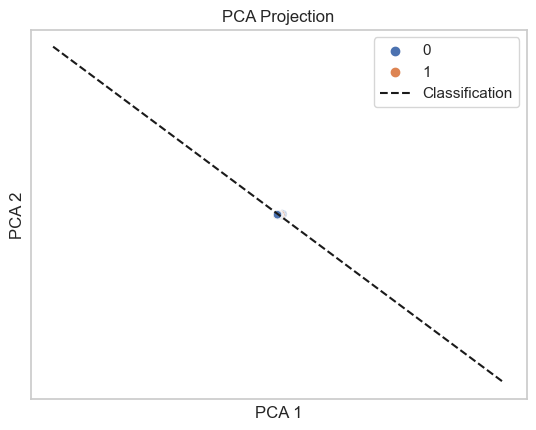

In [16]:
def plot_boundary(model):

    w1 = model.linear1.weight[0][0].detach()
    w2 = model.linear1.weight[0][1].detach()
    b = model.linear1.bias[0].detach()

    x1_min = -1000
    x2_min = (-(w1 * x1_min) - b) / w2

    x1_max = 1000
    x2_max = (-(w1 * x1_max) - b) / w2

    sns.scatterplot(x=x0, y=x1, hue=y)
    plt.title("PCA Projection")
    plt.xlabel("PCA 1")
    plt.ylabel("PCA 2")
    plt.xticks([])
    plt.yticks([])
    plt.plot([x1_min, x1_max], [x2_min, x2_max], color="k", label="Classification", linestyle="--")
    plt.legend()
    plt.show()
    
plot_boundary(model)

**Save model**

In [25]:
# Modelo completo
FILE = "models/model_wplay.pth"
torch.save(model, FILE)

**Load model**

In [26]:
model = torch.load(FILE)
model.eval()

# un parametro para cada variable predictora
for param in model.parameters(): 
    print(param)

Parameter containing:
tensor([[-0.2423, -0.0925, -0.3945, -0.1205, -0.2298, -0.2241, -0.3248, -0.0139,
         -0.1158,  0.1533,  0.2018,  0.0701,  0.1295,  0.3831,  0.0723,  0.1675,
          0.0042, -0.0160,  0.0966,  0.2506, -0.4861,  0.2536, -0.3742,  0.1441,
         -0.5729,  0.9113, -0.4987,  0.6248,  0.0315]], requires_grad=True)
Parameter containing:
tensor([0.3972], requires_grad=True)


**Continue training**

In [ ]:
checkpoint = {
    "epoch": 90,
    "model_state": model.state_dict(),
    "optim_state": optimizer.state_dict()
}